# Q3
#### Ensemble algorithms

#### 0. Imports of libraries that allow the Python code to work

In [1]:
# Load Required Libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model.logistic import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import xgboost as xgb
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve,auc, recall_score

import sklearn.metrics as mt
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk import word_tokenize        
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bharathkarumudi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1. Obtaining and cleaning data

In [2]:
dat = pd.read_csv("data/spam.csv", encoding='latin-1')
dat.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#### Let's start our cleaning:

Let's rename the columns as 'Y' and 'SMS' and replacing the ham with 0 and Spam with 1 and dropping the columns that are not required:

In [3]:
dat = dat.loc[:, ['v1', 'v2']]
dat.rename(columns={'v1': 'y', 'v2': 'sms'}, inplace=True)
dat.y = dat.y.replace({'ham': 0, 'spam': 1})
dat.head()

,y,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#### Onehot Encoding
Removing the stop words which do not add value, create ngrams and also filter the words that appears in almost all or very less apperance.

Some words in the English language, while necessary, don't contribute much to the meaning of a phrase. These words, such as "when", "had", "those" or "before", are called stop words and should be filtered out.

We can tokenize individual terms and generate what's called a bag of words model. You may notice this model has a glaring pitfall: it fails to capture the innate structure of human language. Under this model, the following sentences have the same feature vector although they convey dramatically different meanings.

Does steak taste delicious?
Steak does taste delicious.

Alternatively, we can tokenize every sequence of n terms called n-grams. For example, tokenizing adjacent pairs of words yields bigrams. The n

-gram model preserves word order and can potentially capture more information than the bag of words model.

To get the best of both worlds, let's tokenize unigrams and bigrams. As an example, unigrams and bigrams for "The quick brown fox" are "The", "quick", "brown", "fox", "The quick", "quick brown" and "brown fox".


In [4]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]


def preprocess_txt(raw_text):
    
    processed = raw_text.str.replace(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr')
    processed = processed.str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr')
    processed = processed.str.replace(r'£|\$', 'moneysymb')    
    processed = processed.str.replace(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr')
    processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

    processed = processed.str.replace(r'[^\w\d\s]', ' ')
    processed = processed.str.replace(r'\s+', ' ')
    processed = processed.str.replace(r'^\s+|\s+?$', '')

    processed = processed.str.lower()
    
    return processed
processed = preprocess_txt(dat.sms)

In [5]:
# One hot encode words
vec = TfidfVectorizer(tokenizer=LemmaTokenizer(),
                      stop_words='english', # Remove stop words like a, an, the, etc that do not add much value.
                      ngram_range=(1, 2),   # create unigrams and bigrams.
                      min_df=0.01,          # filter words that appear in less than 1% of records
                      max_df=0.99)          # filter words that appear in more than 99% of records.

X = vec.fit_transform(processed)


In [6]:
message_len = dat.sms.apply(len).values
message_len = message_len / max(message_len)

message_n_words = np.array([len(x) for x in dat.sms.str.split()])
message_n_words = message_n_words / max(message_n_words)

all_caps_freq = np.array([sum(1 for c in message if c.isupper()) for message in dat.sms]) / message_len

avg_word_len = []
for message in dat.sms.str.split():
    message_word_lens = []
    for word in message:
        message_word_lens.append(len(word))
    avg_word_len.append(np.mean(message_word_lens))
avg_word_len = np.array(avg_word_len)


corr_coef, p = pearsonr(message_len, message_n_words) # highly correlated


X = np.column_stack((X.todense(), message_n_words, all_caps_freq, avg_word_len))
X_column_names = vec.get_feature_names() + ['message_n_words', 'all_caps_freq', 'avg_word_len']
X = pd.DataFrame(X, columns=X_column_names)

y = dat.y

* Correlated columns

In [7]:
X1 = X.corr()

correlated_cols = []
corr_threshold = 0.6

print(('row', 'col', 'corr_coef'))

for i in range(len(X1.columns)):
    for j in range(i + 1, len(X1.columns)):
        if np.abs(X1.iloc[i, j]) >= corr_threshold:
            correlated_cols.append((X1.index[i], X1.columns[j], X1.iloc[i, j]))

correlated_cols

('row', 'col', 'corr_coef')


[('don', 'don t', 0.882805593888851),
 ('gon', 'gon na', 0.9952894868075718),
 ('gon', 'na', 0.6228224307454459),
 ('gon na', 'na', 0.6258609343587979),
 ('gt', 'lt', 0.9492251378216033),
 ('gt', 'lt gt', 0.9069499419008591),
 ('lt', 'lt gt', 0.9108650039589136)]

### 2. Classification Models

#### Split into training and test dataset

In [8]:
# Get index of message_n_words
message_n_words_index = [i for i, name in enumerate(X) if name == 'message_n_words']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1234, test_size=0.1)

In [10]:
message_n_words_train = X_train['message_n_words']
message_n_words_test = X_test['message_n_words']

### Logistic Regression

Building the model using logistic regression with cross validation

In [11]:
classifier_lg = LogisticRegressionCV(random_state=1234, class_weight='balanced', n_jobs=-1, cv=10)
classifier_lg.fit(X_train, y_train)

y_pred_train = classifier_lg.predict(X_train)
y_pred_test = classifier_lg.predict(X_test)

print('train recall score: {0}'.format(recall_score(y_pred=y_pred_train, y_true=y_train)))
print('test recall score: {0}'.format(recall_score(y_pred=y_pred_test, y_true=y_test)))

train recall score: 0.9657738095238095
test recall score: 0.9466666666666667


## Tree-based Models

Building the Tree-based models

### Decision Tree

In [12]:
# Decision Tree object
clf_tree = DecisionTreeClassifier(max_depth=5, 
                                  min_samples_split=2, 
                                  random_state=0)

# Train the model using the training set
classifier_tr = clf_tree.fit(X_train, y_train.ravel())

#Predict Output using the test set
predicted_tr = clf_tree.predict(X_test) 

#Confusion matrix for the prediction
cf_test_tr = mt.confusion_matrix(y_test.ravel(), predicted_tr)
print ('Confusion Matrix')
print (cf_test_tr)
print ('Precision = %0.4f' % mt.precision_score(y_test, predicted_tr))
print ('Recall = %0.4f' % mt.recall_score(y_test, predicted_tr))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test, predicted_tr))

Confusion Matrix
[[481   2]
 [ 27  48]]
Precision = 0.9600
Recall = 0.6400
Accuracy = 0.9480


### Bagging

In [13]:
#Bagging object with KNeighbors boundary                     
clf_bg = BaggingClassifier(KNeighborsClassifier(),
                                  max_samples=0.5, max_features=0.5)

# Train the model using the training sets 
classifier_bg = clf_bg.fit(X_train, y_train.ravel())

#Predict Output using the test set
predicted_bg = classifier_bg.predict(X_test)  

#Confusion matrix for the prediction 
cf_test_bg = mt.confusion_matrix(y_test.ravel(), predicted_bg)
print ('Confusion Matrix')
print (cf_test_bg)
print ('Precision = %0.4f' % mt.precision_score(y_test, predicted_bg))
print ('Recall = %0.4f' % mt.recall_score(y_test, predicted_bg))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test, predicted_bg))

Confusion Matrix
[[482   1]
 [ 41  34]]
Precision = 0.9714
Recall = 0.4533
Accuracy = 0.9247


Creating a bagging ensemble of KNeighborsClassifier base estimators, each built on random subsets of 50% of the samples and 50% of the features:  

In [14]:
# As regularization of KNeighbors
best_coeff_bg, best_meas = 0,0
clf_bg = BaggingClassifier(KNeighborsClassifier(),
                                  max_samples=0.5, max_features=0.5)
for i in range(20,80,5):
    clf_bg.set_params(n_estimators=i)
    m = cross_val_score(clf_bg, X_train, y_train.ravel(), scoring='accuracy',cv=5).mean()
    if m > best_meas:
        best_coeff_bg = i
        best_meas = m
    print("n= %i: %0.4f" % (i, m))
print("Best accuracy = %0.4f for n = %i" % (best_meas, best_coeff_bg))

n= 20: 0.9515
n= 25: 0.9521
n= 30: 0.9360
n= 35: 0.9501
n= 40: 0.9471
n= 45: 0.9440
n= 50: 0.9507
n= 55: 0.9509
n= 60: 0.9505
n= 65: 0.9503
n= 70: 0.9531
n= 75: 0.9485
Best accuracy = 0.9531 for n = 70


In [15]:
# Train the model using the new estimators 
clf_bg = BaggingClassifier(KNeighborsClassifier(),n_estimators=best_coeff_bg, max_samples=0.5, 
                           max_features=0.5)
classifier_bg = clf_bg.fit(X_train, y_train.ravel())
m = cross_val_score(clf_bg, X_test, y_test.ravel(), scoring='accuracy',cv=5).mean()

#Confusion matrix 
print ('Confusion Matrix')
print (cf_test_bg)
print("Accuracy: %0.4f" % m)
m = cross_val_score(clf_bg, X_test, y_test.ravel(), scoring='precision',cv=5).mean()
print("Precision: %0.4f" % m)
m = cross_val_score(clf_bg, X_test, y_test.ravel(), scoring='recall',cv=5).mean()
print("Recall: %0.4f" % m)

Confusion Matrix
[[482   1]
 [ 41  34]]
Accuracy: 0.8835
Precision: 1.0000
Recall: 0.1067


### Adaptive Boosting

In [16]:
# Build a AdaBoosting object
clf_adaB = AdaBoostClassifier(n_estimators=35)

# Train the model using the training sets 
classifier_adaB = clf_adaB.fit(X_train, y_train.ravel())

#Predict Output using the test set
predicted_adaB = clf_adaB.predict(X_test)  

#Confusion matrix for the prediction 
cf_test_adaB = mt.confusion_matrix(y_test.ravel(), predicted_adaB)
print ('Confusion Matrix')
print (cf_test_adaB)
print ('Precision = %0.4f' % mt.precision_score(y_test, predicted_adaB))
print ('Recall = %0.4f' % mt.recall_score(y_test, predicted_adaB))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test, predicted_adaB))

Confusion Matrix
[[480   3]
 [ 11  64]]
Precision = 0.9552
Recall = 0.8533
Accuracy = 0.9749


### Random forest

In [17]:
# Build a Random forest object
clf_forest = RandomForestClassifier(n_estimators=2000, # numbers of tree in the forest
                                    criterion='gini',
                                    max_depth=None,
                                    class_weight='balanced',
                                    min_samples_split=2,
                                    random_state=0)

# Train the random forest model using the training sets 
classifier_rf = clf_forest.fit(X_train, y_train.ravel())

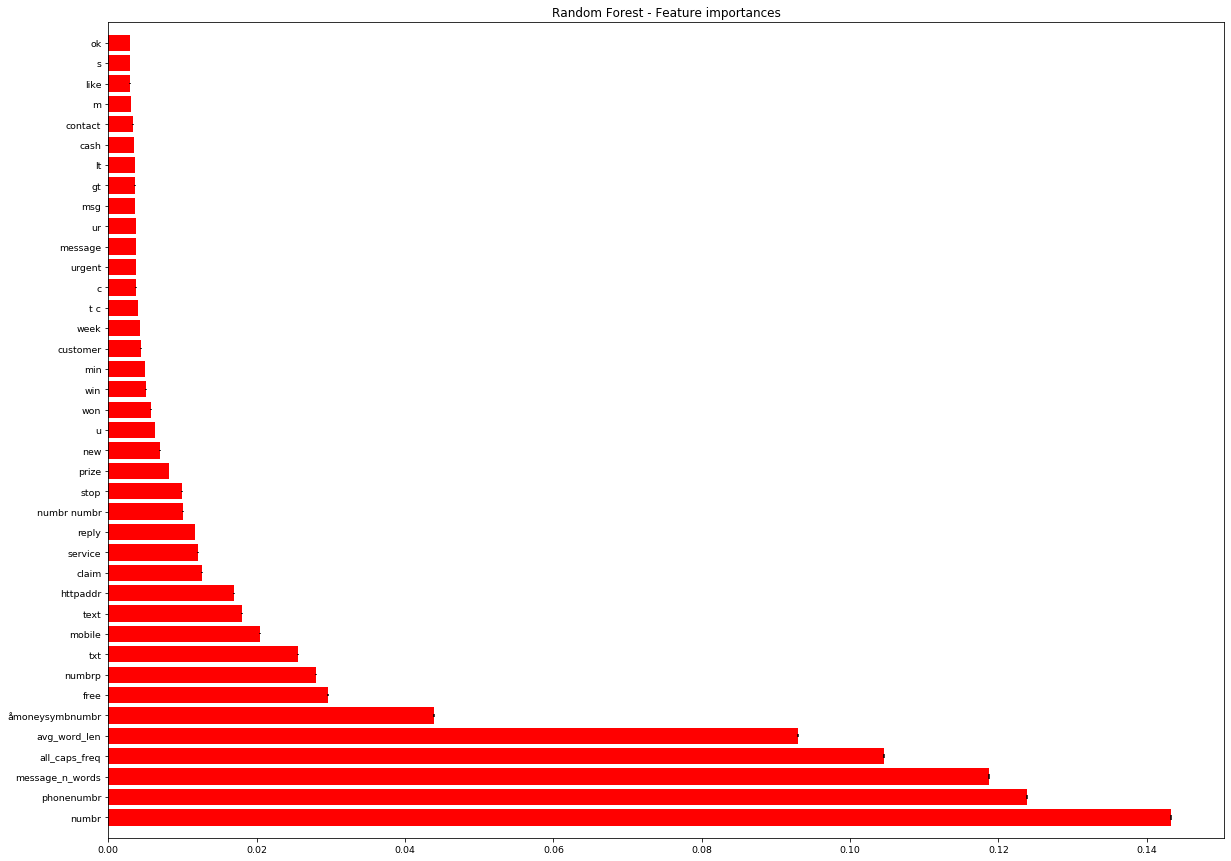

In [18]:
# Take the random forest fit and compute the feature importances
importances_rf = clf_forest.feature_importances_
std_rf = np.std([tree.feature_importances_ for tree in clf_forest.estimators_],
             axis=0)
indices_rf = np.argsort(importances_rf)[::-1]

# Plot the feature importances of the forest
almost_black = '#262626'
indices_rf_restr = np.argsort(importances_rf)[:93:-1]
labels = []
for l in X_train.columns[indices_rf_restr]:
    labels.append(l)
plt.figure(figsize=(20,15))
plt.title("Random Forest - Feature importances", fontsize=12)
plt.barh(range(indices_rf_restr.shape[0]), importances_rf[indices_rf_restr],
       color="r", yerr=std_rf[indices_rf_restr], align="center")
plt.yticks(range(indices_rf_restr.shape[0]), labels, fontsize=9.4)
plt.xticks(fontsize=9.4)
plt.ylim([-1, indices_rf_restr.shape[0]])
plt.show()

In [19]:
predicted_rf =  clf_forest.predict(X_test)                           

#Confusion matrix for the prediction 
cf_test_rf = mt.confusion_matrix(y_test.ravel(), predicted_rf)
print ('Confusion Matrix')
print (cf_test_rf)
print ('Precision = %0.4f' % mt.precision_score(y_test, predicted_rf))
print ('Recall = %0.4f' % mt.recall_score(y_test, predicted_rf))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test, predicted_rf))

Confusion Matrix
[[481   2]
 [ 11  64]]
Precision = 0.9697
Recall = 0.8533
Accuracy = 0.9767


### Gradient Boosting

In [20]:
#Gradient Boosting object and fitted the model
clf_GradBoost = GradientBoostingClassifier(n_estimators=500, subsample=0.3, 
                                           learning_rate=0.1,
                                           max_depth=1, 
                                           random_state=0).fit(X_train, y_train.ravel())

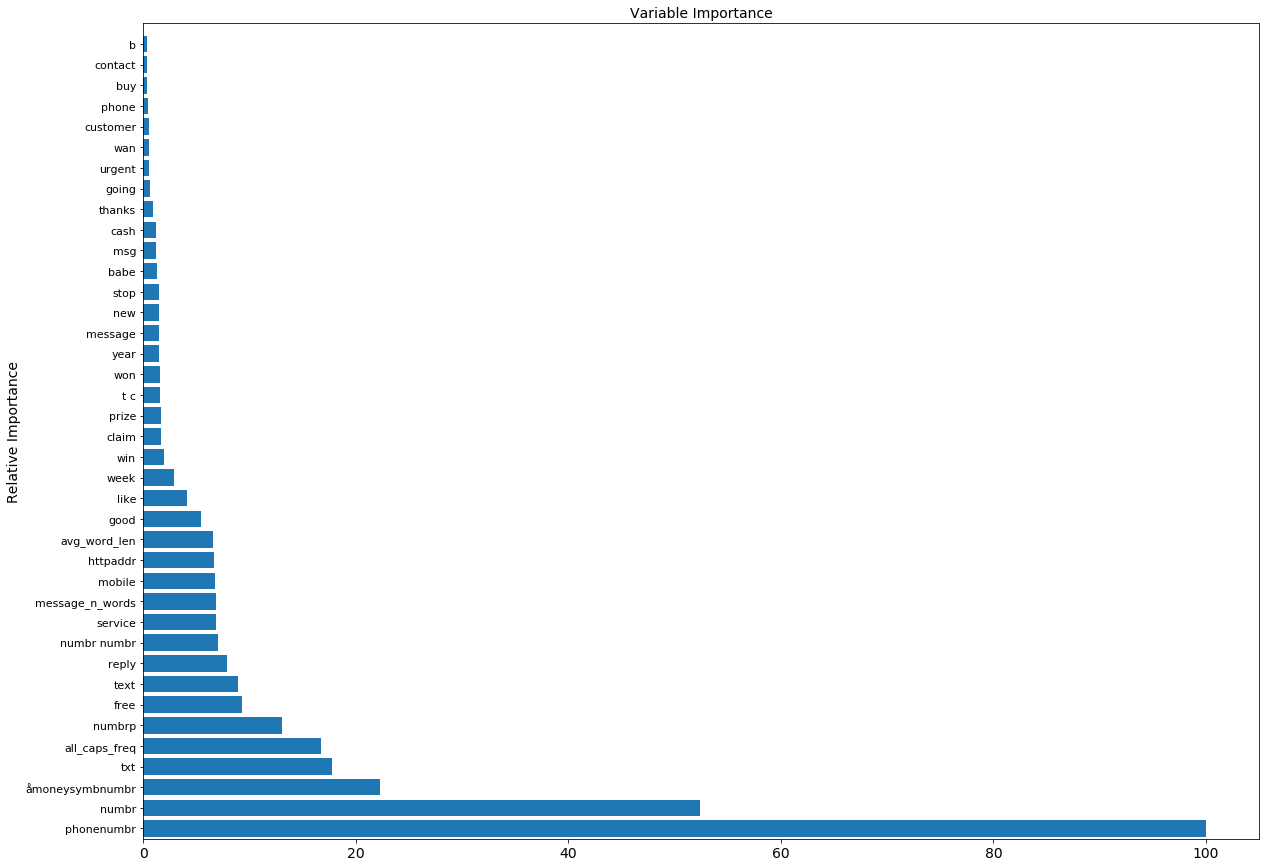

In [21]:
# # feature importance for Gradient Boosting
importances_gbm = clf_GradBoost.feature_importances_ 
indices_gbm = np.argsort(importances_gbm)[::-1]

# make importances relative to max importance

feature_importance_gbm = 100.0 *(importances_gbm / importances_gbm.max())

sorted_idx = np.argsort(feature_importance_gbm)[:93:-1]


labels = []
for l in X_train.columns[sorted_idx]:
    labels.append(l)
pos = np.arange(sorted_idx.shape[0]) 
plt.figure(figsize=(20,15))
plt.barh(pos, feature_importance_gbm[sorted_idx], align='center')
plt.xticks(fontsize=14)
plt.yticks(range(sorted_idx.shape[0]),labels, fontsize=11)
plt.ylabel('Relative Importance', fontsize=14)
plt.title('Variable Importance', fontsize=14)
plt.ylim([-0.5, sorted_idx.shape[0]])
plt.show()

In [22]:
#Predict Output using the test set
predicted_gbm = clf_GradBoost.predict(X_test)                 

#Confusion matrix for the prediction 
cf_test_gbm = mt.confusion_matrix(y_test, predicted_gbm)
print ('Confusion Matrix')
print (cf_test_gbm)
print ('Precision = %0.4f' % mt.precision_score(y_test, predicted_gbm))
print ('Recall = %0.4f' % mt.recall_score(y_test, predicted_gbm))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test, predicted_gbm))

Confusion Matrix
[[483   0]
 [ 13  62]]
Precision = 1.0000
Recall = 0.8267
Accuracy = 0.9767


### Extreme Gradient Boosting

In [23]:
## Build a XgBoosting object
clf_xgb = xgb.XGBClassifier(max_depth = 5,
                            n_estimators=500,
                            learning_rate=0.01,
                            nthread=6,
                            subsample=0.95,
                            colsample_bytree=0.90,
                            seed=4241)
classifier_xgb = clf_xgb.fit(X_train, y_train.ravel())

#Predict Output using the test set
predicted_xgb = clf_xgb.predict(X_test)  

#Confusion matrix for the prediction 
cf_test_xgb = mt.confusion_matrix(y_test.ravel(), predicted_xgb)
print ('Confusion Matrix')
print (cf_test_xgb)
print ('Precision = %0.4f' % mt.precision_score(y_test, predicted_xgb))
print ('Recall = %0.4f' % mt.recall_score(y_test, predicted_xgb))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test, predicted_xgb))

Confusion Matrix
[[481   2]
 [ 13  62]]
Precision = 0.9688
Recall = 0.8267
Accuracy = 0.9731


### Support Vector Machine

This model is not going to do well. Feaure space is sparse. PCA on sparse does not do well. 

In [24]:
# Normalize dataset before 
data = X
t = y
data_pca = preprocessing.normalize(data)

# Perform an eigendecomposition on the covariance matrix
cor_mat = np.corrcoef(data_pca.T)
eig_vals, eig_vecs = np.linalg.eig(cor_mat)

#Explained Variance
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

#Perform a principal component analysis 
X_pca = TruncatedSVD(n_components=6).fit_transform(data_pca)

#Build a principal component analysis
X_trainpca, X_testpca, y_trainpca, y_testpca = train_test_split(X_pca, t, 
                                                    test_size=0.33, random_state=1234)
# Build a Support vector machine object
clf_SVM_kernel = svm.SVC(probability=True, cache_size=1000, kernel='linear', C=1, gamma=1)
classifier_SVM_kernel = clf_SVM_kernel.fit(X_trainpca, y_trainpca.ravel())

#Predict Output using the test set
predicted_svm = classifier_SVM_kernel.predict(X_testpca)

#Confusion matrix for the prediction 
cf_test = mt.confusion_matrix(y_testpca, predicted_svm)
print ('Confusion Matrix')
print (cf_test)
print ('Precision = %0.4f' % mt.precision_score(y_testpca, predicted_svm))
print ('Recall = %0.4f' % mt.recall_score(y_testpca, predicted_svm))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_testpca, predicted_svm))

Confusion Matrix
[[1575    0]
 [ 264    0]]
Precision = 0.0000
Recall = 0.0000
Accuracy = 0.8564


### Conclusions

In [25]:
# Learn to predict each class against the other (for test sample)
colors= sns.color_palette("Set2", 10)

y_prob_lg = classifier_lg.predict_proba(X_test)
y_prob_rf = classifier_rf.predict_proba(X_test)
y_prob_tr = classifier_tr.predict_proba(X_test)
y_prob_gbm = clf_GradBoost.predict_proba(X_test)
y_prob_adaB = classifier_adaB.predict_proba(X_test)
y_prob_xgb = classifier_xgb.predict_proba(X_test)
y_prob_bg = classifier_bg.predict_proba(X_test)
y_prob_SVM= classifier_SVM_kernel.predict_proba(X_testpca)

# define the roc curse parameters
fpr_lg, tpr_lg, thresholds_lg = roc_curve(np.array(y_test), y_prob_lg[:,1], pos_label=1)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(np.array(y_test), y_prob_rf[:,1], pos_label=1)
fpr_tr, tpr_tr, thresholds_tr = roc_curve(np.array(y_test), y_prob_tr[:,1], pos_label=1)
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(np.array(y_test), y_prob_gbm[:,1], pos_label=1)
fpr_adaB, tpr_adaB, thresholds_adaB = roc_curve(np.array(y_test), y_prob_adaB[:,1], pos_label=1)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(np.array(y_test), y_prob_xgb[:,1], pos_label=1)
fpr_bg, tpr_bg, thresholds_bg = roc_curve(np.array(y_test), y_prob_bg[:,1], pos_label=1)
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(np.array(y_testpca), y_prob_SVM[:,1], pos_label=1)

# plot the roc curves
plt.figure(figsize=(16,8), dpi=1600)
plt.plot(fpr_lg, tpr_lg, color=colors[0],label='ROC curve Logistic Regression (area = %0.2f)' % auc(fpr_lg, tpr_lg))
plt.plot(fpr_tr, tpr_tr, color=colors[1],label='ROC curve Decision Tree (area = %0.2f)' %  auc(fpr_tr, tpr_tr))
plt.plot(fpr_rf, tpr_rf, color=colors[2],label='ROC curve Random Forest (area = %0.2f)' %  auc(fpr_rf, tpr_rf))
plt.plot(fpr_gbm, tpr_gbm, color=colors[3],label='ROC curve Gradient Boosting (area = %0.2f)' %  auc(fpr_gbm, tpr_gbm))
plt.plot(fpr_SVM, tpr_SVM, color=colors[4],label='ROC curve Support Vector Machine (area = %0.2f)' %  auc(fpr_SVM, tpr_SVM))
plt.plot(fpr_adaB, tpr_adaB, color=colors[5],label='ROC curve AdaBoosting (area = %0.2f)' %  auc(fpr_adaB, tpr_adaB))
plt.plot(fpr_bg, tpr_bg, color=colors[6],label='ROC curve Bagging (area = %0.2f)' %  auc(fpr_bg, tpr_bg))
plt.plot(fpr_xgb, tpr_xgb, color=colors[7],label='ROC curve XGB (area = %0.2f)' %  auc(fpr_xgb, tpr_xgb))

plt.plot([0, 1], [0, 1],'k-', linewidth=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel(r'True Positive Rate $TPR=\frac{TP}{P}=\frac{TP}{TP+FN}$', fontsize=12)
plt.ylabel(r'False Positive Rate $FPR=\frac{FP}{N}=\frac{FP}{TP+FN}$', fontsize=12)
plt.title('Receiver operating characteristic', fontsize=14)
plt.grid(color='white', linestyle='dashed')
plt.legend(loc="lower right", fontsize=14)
plt.show()

In [26]:
# Area under curve
print ('AUC LG = %0.3f' % auc(fpr_lg, tpr_lg))
print ('AUC DT = %0.3f' % auc(fpr_tr, tpr_tr))
print ('AUC RF = %0.3f' % auc(fpr_rf, tpr_rf))
print ('AUC GBM = %0.3f' % auc(fpr_gbm, tpr_gbm))
print ('AUC AdaBoosting = %0.3f' % auc(fpr_adaB, tpr_adaB))
print ('AUC Bagging = %0.3f' % auc(fpr_bg, tpr_bg))
print ('AUC SVM = %0.3f' % auc(fpr_SVM, tpr_SVM))
print ('AUC XGB = %0.3f' % auc(fpr_xgb , tpr_xgb))

AUC LG = 0.989
AUC DT = 0.829
AUC RF = 0.991
AUC GBM = 0.988
AUC AdaBoosting = 0.980
AUC Bagging = 0.963
AUC SVM = 0.269
AUC XGB = 0.988


### References:
[1] https://github.com/mgiacalone1980/machine-learning-assignment  
[2] Dataset: https://www.kaggle.com/uciml/sms-spam-collection-dataset/